## Loading preprosed data

In [1]:
LEVEL="mnist"

In [2]:
PATH = "../weights/wgan_{}".format(LEVEL)

In [3]:
BATCH_SIZE=128
LAMBDA = 10
STEPS_PER_EPOCH = int(60000/BATCH_SIZE)+1
NUM_EPOCH = 200

In [4]:
import tensorflow as tf
tf.__version__

'1.9.0'

# Model

## Discriminator

In [5]:
def discriminator(x, is_training):

    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE) as scope:
        print('discriminator')
        conv1 = tf.layers.conv2d(
            inputs=x,
            filters=16,
            kernel_size=[3,3],
            strides=(2,2),
            padding="same",
            activation=tf.nn.leaky_relu,
            name = "dconv1")
        print(conv1.shape)
        # Convolutional Layer #2
        conv2 = tf.layers.conv2d(
            inputs=conv1,
            filters=32,
            kernel_size=[3,3],
            strides=(2,2),
            padding="same",
            activation=tf.nn.leaky_relu,
            name = "dconv2")
        print(conv2.shape)
        conv3 = tf.layers.conv2d(
            inputs=conv2,
            filters=64,
            kernel_size=[3,3],
            strides=(2,2),
            padding="same",
            activation=tf.nn.leaky_relu,
            name = "dconv3")
        print(conv3.shape)
        flat = tf.layers.flatten(conv3, name="dflat")
        output = tf.layers.dense(inputs=flat,
                                 activation=None,
                                 units=1,
                                 name="doutput")
        print(output.shape)
        output = tf.reshape(output, [-1])
        print(output.shape)
        return output

# Generator

In [6]:
def generator(input_batch=None, is_training=True):
    with tf.variable_scope('generator') as scope:
        print('generator')
        if input_batch is None:
            input_batch = tf.random_normal([BATCH_SIZE, 128])
        print (input_batch.shape)   
        dense1 = tf.layers.dense(inputs=input_batch,
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                 bias_initializer=tf.zeros_initializer(),
                                 units=7*7*64,
                                 activation=tf.nn.relu,
                                 name="dense1")
        reshaped1 = tf.reshape(dense1, shape=[-1, 7, 7, 64], name='reshape1')
        print(reshaped1.shape)
        up1 = tf.keras.layers.UpSampling2D(size=(2, 2))(reshaped1)
        conv2 = tf.layers.conv2d(inputs=up1, 
                                 filters=32,
                                 kernel_size=[3,3],
                                 padding="same",
                                 activation=tf.nn.relu,
                                 name = "conv2")
        print(conv2.shape)
        up2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv2)
        conv3 = tf.layers.conv2d(inputs=up2, 
                                 filters=16,
                                 kernel_size=[3,3],
                                 padding="same",
                                 activation=tf.nn.relu,
                                 name = "conv3")
        print(conv3.shape) 
        
        conv4 = tf.layers.conv2d(inputs=conv3, 
                                 filters=1,
                                 kernel_size=[3,3],
                                 padding="same",
                                 activation=tf.nn.sigmoid,
                                 name = "conv4")    
        print(conv4.shape)
        return conv4

## Graph

In [7]:
tf.reset_default_graph()
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

with tf.variable_scope('input'):
    real  = tf.placeholder(tf.float32, shape=[None, 784]) 
    is_training = tf.placeholder(tf.bool, name='is_train')
real_reshaped = tf.reshape(real, shape=[BATCH_SIZE, 28, 28, 1], name='real')

In [8]:
fake = generator(is_training=is_training)
logits_real = discriminator(real_reshaped, is_training)
logits_fake = discriminator(fake, is_training)
d_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real) # This optimizes the discriminator.
g_loss = -tf.reduce_mean(logits_fake)  # This optimizes the generator.

# # wgan-gp gradient panelty 
with tf.name_scope("Gradient_penalty"):
    eps = tf.random_uniform([BATCH_SIZE,1, 1, 1], minval=0.0,maxval=1.0)
    interpolates = real_reshaped + eps*(fake - real_reshaped)

    gradients = tf.gradients(discriminator(interpolates, is_training), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.))
    d_loss += 10 * gradient_penalty
    
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
print (D_vars)
print (G_vars)
trainer_d = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9).minimize(d_loss, var_list=D_vars)
trainer_g = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9).minimize(g_loss, var_list=G_vars)

# clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in D_vars]


generator
(128, 128)
(128, 7, 7, 64)
(128, 14, 14, 32)
(128, 28, 28, 16)
(128, 28, 28, 1)
discriminator
(128, 14, 14, 16)
(128, 7, 7, 32)
(128, 4, 4, 64)
(128, 1)
(128,)
discriminator
(128, 14, 14, 16)
(128, 7, 7, 32)
(128, 4, 4, 64)
(128, 1)
(128,)
discriminator
(128, 14, 14, 16)
(128, 7, 7, 32)
(128, 4, 4, 64)
(128, 1)
(128,)
[<tf.Variable 'discriminator/dconv1/kernel:0' shape=(3, 3, 1, 16) dtype=float32_ref>, <tf.Variable 'discriminator/dconv1/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'discriminator/dconv2/kernel:0' shape=(3, 3, 16, 32) dtype=float32_ref>, <tf.Variable 'discriminator/dconv2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'discriminator/dconv3/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'discriminator/dconv3/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'discriminator/doutput/kernel:0' shape=(1024, 1) dtype=float32_ref>, <tf.Variable 'discriminator/doutput/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'generator/dense

## Helpers for training model

## Review generated examples

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [10]:
def display_generated():
    print ('Generating numbers...')
    generated_number = sess.run([fake], feed_dict={is_training: False})
    a = plot(generated_number[0][0:16])

In [11]:
 def save_weights(saver, sess, path):
    save_path = saver.save(sess, path)
    print("Model saved in path: %s" % save_path)

In [12]:
def print_summary(steps, dLoss, gLoss):    
    if steps % int(STEPS_PER_EPOCH/5) == 0:
        print('steps:{}, d_loss:{:.4f} ,g_loss:{:.4f}'.format(
            steps, dLoss, gLoss))

In [13]:
import datetime
def save_model(saver, sess):
    # Epoch ended
    if steps % STEPS_PER_EPOCH == 0:
        print("Epoch {}. Fineshed at {}".format((steps/STEPS_PER_EPOCH), str(datetime.datetime.now()).split('.')[0]))
        display_generated()
        save_weights(saver, sess, PATH)

## Running model

In [14]:
sess = tf.Session()
saver = tf.train.Saver(max_to_keep=3)
sess.run(tf.global_variables_initializer())

In [19]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print ("Start training with batch size: {}, epoch num: {}".format(BATCH_SIZE, NUM_EPOCH))
steps, gen_iterations = 0, 0
gLoss = 0

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Start training with batch size: 128, epoch num: 200


steps:93, d_loss:-3.4098 ,g_loss:0.0000
steps:186, d_loss:-2.9466 ,g_loss:-33.8132
steps:279, d_loss:-3.5477 ,g_loss:-27.4887
steps:372, d_loss:-3.4878 ,g_loss:-18.4166
steps:465, d_loss:-3.5244 ,g_loss:-15.4115
Epoch 1.0. Fineshed at 2018-08-05 18:06:33
Generating numbers...
Model saved in path: ../weights/wgan_mnist
steps:558, d_loss:-3.2210 ,g_loss:-17.9475
steps:651, d_loss:-3.5875 ,g_loss:-25.2599
steps:744, d_loss:-4.1474 ,g_loss:-27.8084
steps:837, d_loss:-3.7573 ,g_loss:-24.0988
steps:930, d_loss:-3.9615 ,g_loss:-23.7984
Epoch 2.0. Fineshed at 2018-08-05 18:07:03
Generating numbers...
Model saved in path: ../weights/wgan_mnist
steps:1023, d_loss:-3.7703 ,g_loss:-22.4677
steps:1116, d_loss:-3.3005 ,g_loss:-25.8893
steps:1209, d_loss:-3.9759 ,g_loss:-25.8893
steps:1302, d_loss:-4.3038 ,g_loss:-23.0788
steps:1395, d_loss:-4.2327 ,g_loss:-25.0047
Epoch 3.0. Fineshed at 2018-08-05 18:07:33
Generating numbers...
Model saved in path: ../weights/wgan_mnist
steps:1488, d_loss:-4.5969 ,g

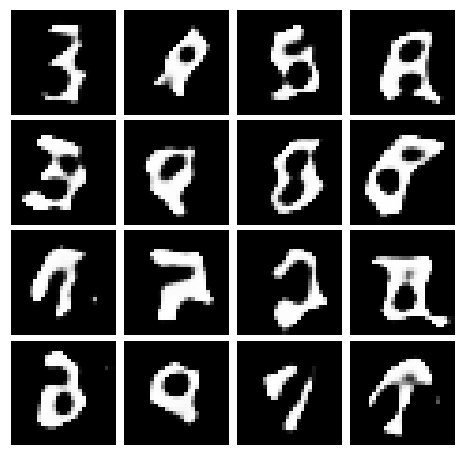

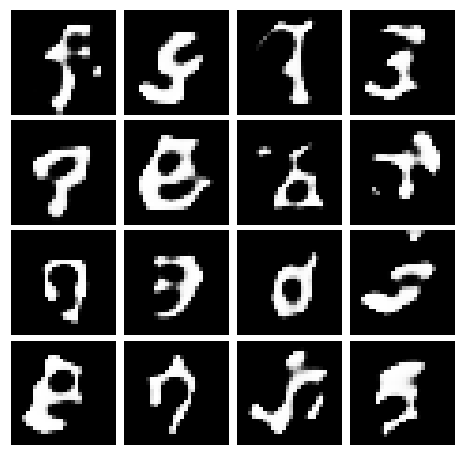

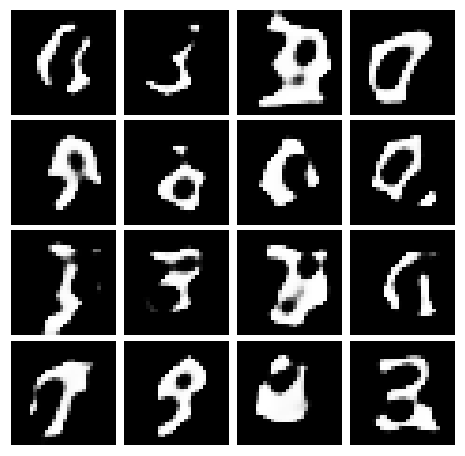

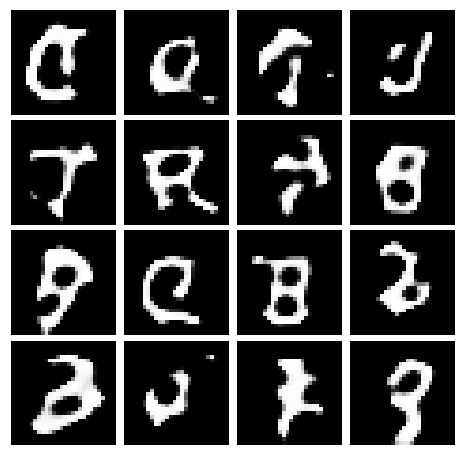

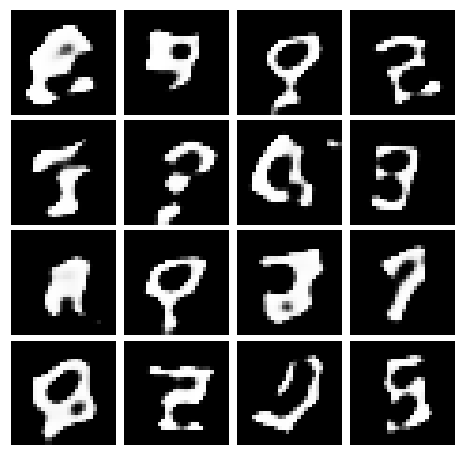

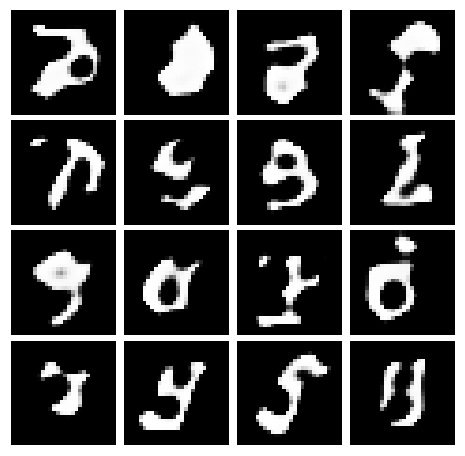

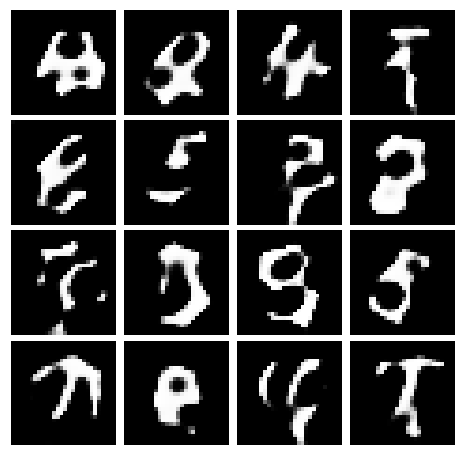

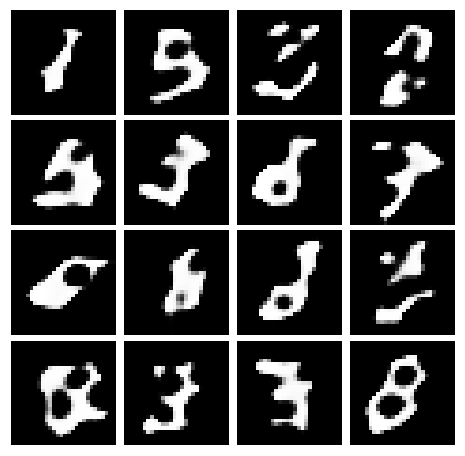

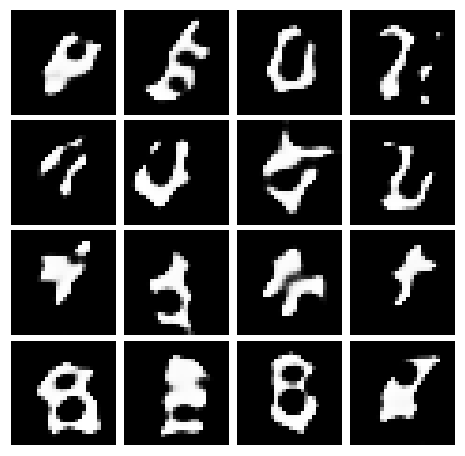

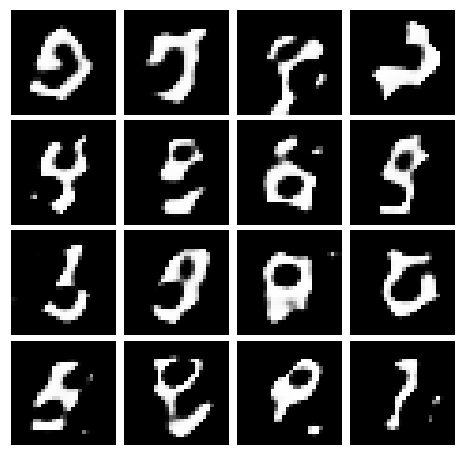

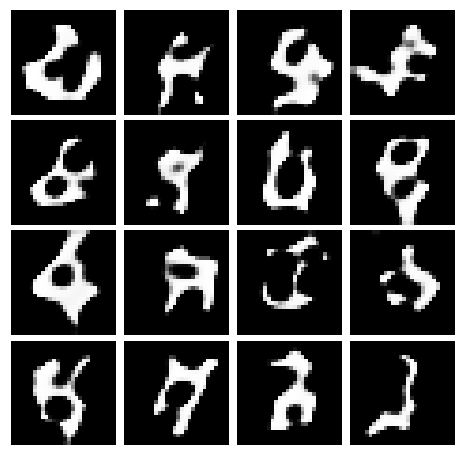

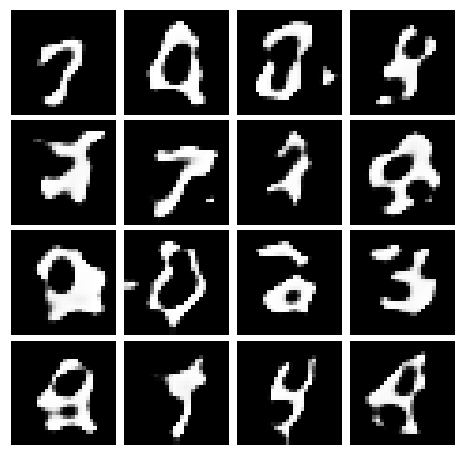

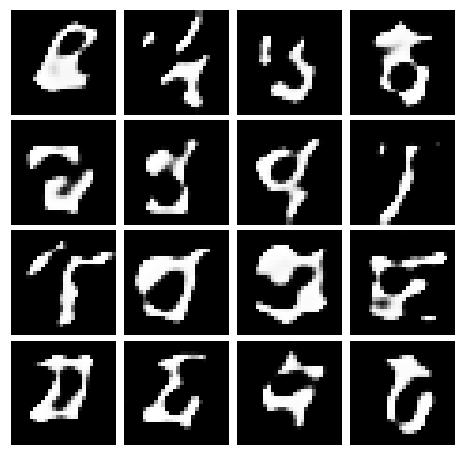

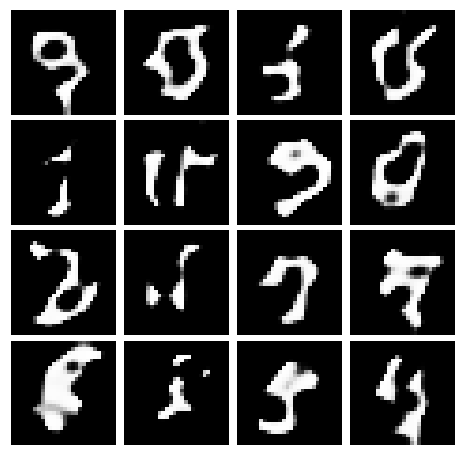

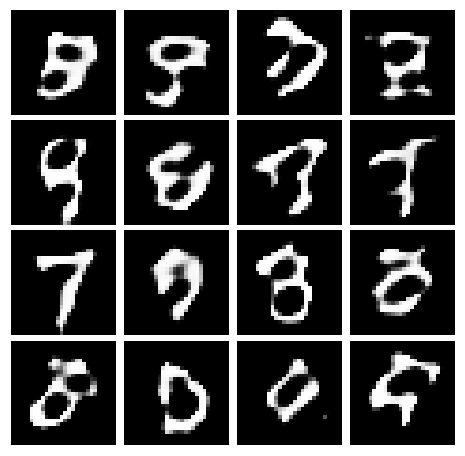

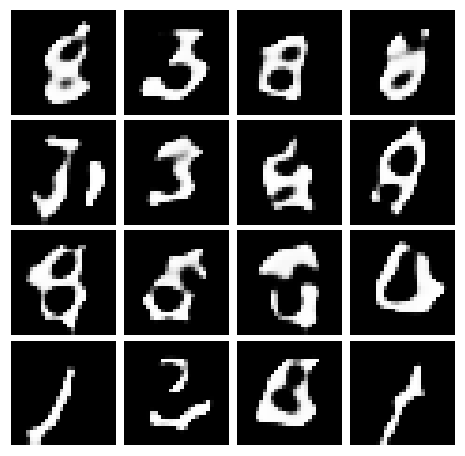

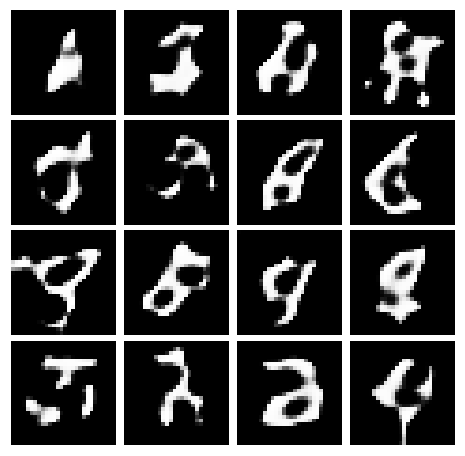

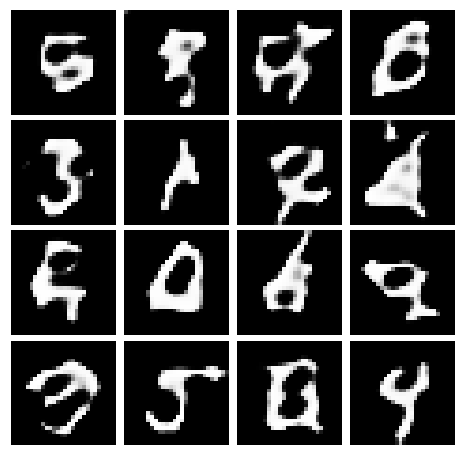

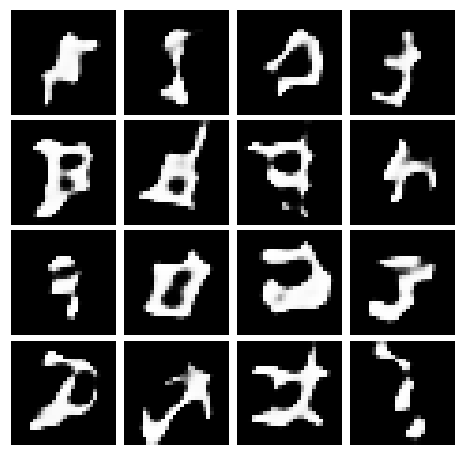

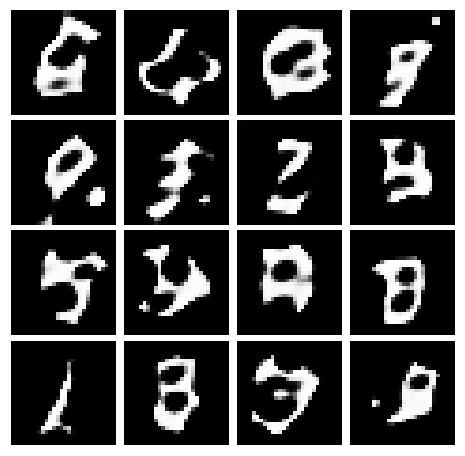

In [20]:
while steps <= STEPS_PER_EPOCH*20:
    d_iters = (100 if gen_iterations < 25 or gen_iterations % 500 == 0 else 5)
    for k in range(d_iters): # Discriminator
        real_batch, label = mnist.train.next_batch(BATCH_SIZE)
        _, dLoss = sess.run([trainer_d, d_loss], feed_dict={real: real_batch, is_training: True})
        steps = steps + 1
        print_summary(steps, dLoss, gLoss)
        save_model(saver, sess)

    # Generator
    _, gLoss = sess.run([trainer_g, g_loss], feed_dict={is_training: True})
    steps = steps + 1
    gen_iterations = gen_iterations + 1
    print_summary(steps, dLoss, gLoss)
    save_model(saver, sess)
print("Training is finished")


## Validation of discriminator

In [16]:
def mean(l):
    return sum(l) / float(len(l))

In [17]:
val_real = discriminator(real_reshaped, is_training, reuse=True)
val_fake = discriminator(embedded_random_sequences, is_training, reuse=True)
val_loss = tf.reduce_mean(val_real-val_fake)
real_predictions = tf.rint(val_real)
fake_predictions = tf.rint(val_fake)
correct_real_predictions = tf.equal(real_predictions, tf.zeros([BATCH_SIZE], dtype=tf.float32))
correct_fake_predictions = tf.equal(fake_predictions, tf.ones([BATCH_SIZE], dtype=tf.float32))
casted_real = tf.cast(correct_real_predictions, tf.float32)
casted_fake = tf.cast(correct_fake_predictions, tf.float32)
accuracy = (tf.reduce_mean(casted_real) + tf.reduce_mean(casted_fake))/2

TypeError: discriminator() got an unexpected keyword argument 'reuse'

In [ ]:
#Validate discriminator by giving from validate data set and randomly generated
print ('validating discriminator...')
sess.run(iterator.initializer, 
         feed_dict={real_sequences: val_data, random_sequences: get_random_sequence(val_data.shape[0])})
losses = []
accuracies = []
while True:
    try:
        v_loss, v_accuracy = sess.run([val_loss, accuracy], feed_dict={is_training: False})
        losses.append(v_loss)
        accuracies.append(v_accuracy)
    except tf.errors.OutOfRangeError:
        print ('Validation g_loss:{:.4f} ,accuracy :{:.4f}'.format(mean(losses), mean(accuracies)))
        break

Generating numbers...


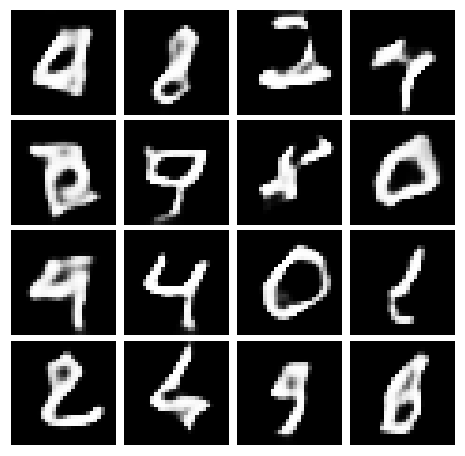

In [18]:
display_generated()

In [15]:
def restore_weights(saver, sess, path):
    saver.restore(sess, path)
    print("Model restored.")

In [16]:
restore_weights(saver, sess, PATH)

INFO:tensorflow:Restoring parameters from ../weights/wgan_mnist
Model restored.


In [59]:
np.random.uniform(-1., 1., size=[BATCH_SIZE, 100])

array([[-0.93914259,  0.53939226, -0.30407487, ...,  0.67620527,
         0.91757   , -0.72460847],
       [ 0.96005937, -0.58254639,  0.18113382, ...,  0.81485647,
         0.51689731, -0.51772042],
       [-0.11100242,  0.68354875,  0.27676933, ..., -0.56037988,
         0.60195004,  0.52021887],
       ...,
       [-0.83609721, -0.7870614 , -0.27849695, ..., -0.68939098,
        -0.39457356, -0.40048813],
       [-0.95756   ,  0.32275007,  0.97120863, ..., -0.8473995 ,
        -0.04844512, -0.9825589 ],
       [ 0.83989046, -0.15841559,  0.62887061, ..., -0.30293849,
        -0.19086035, -0.02141159]])

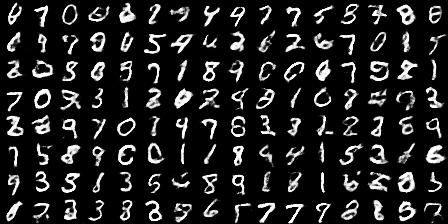

In [8]:
from IPython.display import Image
Image(filename='/home/donatasrep/workspace/improved_wgan_training/samples_5399.png') 